# M&Ns: An ASL Letter Convolutional Neural Network

Model Adapted from: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

Dataset from: https://www.kaggle.com/grassknoted/asl-alphabet

## Accessing Data

The dataset was stored on the Lustre filesystem on _Expanse_. 

In [1]:
#First Step: getting into the correct directory
import os
os.chdir("/expanse/lustre/scratch/liatzheng/temp_project/")
!pwd

/expanse/lustre/scratch/liatzheng/temp_project


## Plot M and N
Looking at a few random photos in the directory, you can see that the photos are color and have different shapes and sizes.

For example, let’s load and plot the first nine photos of the letter M in a single figure.

The complete example is listed below.

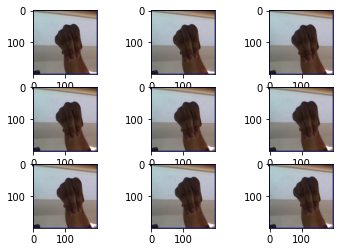

In [2]:
# plot M photos from the dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = ('asl_m_n/')
# plot first few images
for i in range(1, 10):
    # define subplot
    pyplot.subplot(330 + i)
    # define filename
    filename = folder + 'M' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

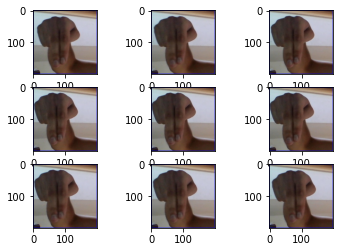

In [3]:
# plot N photos from the dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'asl_m_n/'
# plot first few images
for i in range(1, 10):
    # define subplot
    pyplot.subplot(330 + i)
    # define filename
    filename = folder + 'N' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

## Pre-Process Photo Sizes

In [ ]:
# load dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = 'asl_m_n/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
    # determine class
    output = 0.0
    if file.startswith('N'):
        output = 1.0
    # load image
    try: 
        photo = load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
        photo = img_to_array(photo)
    # store
        photos.append(photo)
        labels.append(output)
    except:
        print("Corrupt Image.") #means one of the images is corrupted
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('m_n_photos.npy', photos)
save('m_n_labels.npy', labels)

In [4]:
# load and confirm the shape
from numpy import load
photos = load('m_n_photos.npy')
labels = load('m_n_labels.npy')
print(photos.shape, labels.shape)

(6000, 200, 200, 3) (6000,)


In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_m_n/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['M/', 'N/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'asl_m_n/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('N'):
        dst = dataset_home + dst_dir + 'N/'  + file
        copyfile(src, dst)
    elif file.startswith('M'):
        dst = dataset_home + dst_dir + 'M/'  + file
        copyfile(src, dst)

## Develop a Baseline CNN Model (One Block)
The one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.

The define_model() function for this model was defined in the previous section but is provided again below for completeness.

In [2]:
# baseline model for the dataset
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [5]:
# run the test harness for evaluating a model
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass
        

In [9]:
def run_test_harness():
    global history
    global validation_data
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_m_n/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_m_n/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    #history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    history = model.fit(my_gen(train_it), steps_per_epoch=len(train_it),
        #validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
        validation_data=my_gen(test_it), validation_steps=len(test_it), epochs=30, verbose=1)
    # evaluate model
    #_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    _, acc = model.evaluate(my_gen(test_it), steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

In [ ]:
# entry point, run the test harness
run_test_harness()

In [ ]:
#First, get the values of loss and accuracy
history.history.keys()


In [ ]:
#plot train vs test accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = "train")
plt.plot(history.history['val_accuracy'], label = "test")
#plt.plot(validation_data.history['accuracy'], label = "train")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#plot train vs test loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = "test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

## Two Block VGG Model

The two-block VGG model extends the one block model and adds a second block with 64 filters.

The define_model() function for this model is provided below for completeness.

In [ ]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
run_test_harness()

In [ ]:
#plot train vs test accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = "train")
plt.plot(history.history['val_accuracy'], label = "test")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#plot train vs test loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = "test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

## Three Block Model
The three-block VGG model extends the two block model and adds a third block with 128 filters.

The define_model() function for this model was defined in the previous section but is provided again below for completeness.

In [10]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
run_test_harness()

In [ ]:
#plot train vs test accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = "train")
plt.plot(history.history['val_accuracy'], label = "test")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#plot train vs test loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = "test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

We see a trend of improved performance with the increase in capacity, but also a similar case of overfitting occurring earlier and earlier in the run.

The results suggest that the model will likely benefit from regularization techniques. This may include techniques such as dropout, weight decay, and data augmentation. The latter can also boost performance by encouraging the model to learn features that are further invariant to position by expanding the training dataset.

## Dropout Regularization
Dropout regularization is a computationally cheap way to regularize a deep neural network.

Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structures and, in turn, making nodes in the network generally more robust to the inputs.

Typically, a small amount of dropout can be applied after each VGG block, with more dropout applied to the fully connected layers near the output layer of the model.

Below is the define_model() function for an updated version of the baseline model with the addition of Dropout.

In [10]:
# define cnn model
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
run_test_harness()

Found 4501 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Epoch 1/30
71/71 [==============================] - 54s 664ms/step - loss: 0.7453 - accuracy: 0.5759 - val_loss: 0.6584 - val_accuracy: 0.6278
Epoch 2/30
71/71 [==============================] - 9s 129ms/step - loss: 0.6147 - accuracy: 0.6476 - val_loss: 0.6064 - val_accuracy: 0.7345
Epoch 3/30
71/71 [==============================] - 9s 128ms/step - loss: 0.5671 - accuracy: 0.6976 - val_loss: 0.6219 - val_accuracy: 0.5964
Epoch 4/30
71/71 [==============================] - 9s 127ms/step - loss: 0.5257 - accuracy: 0.7234 - val_loss: 0.5301 - val_accuracy: 0.7652
Epoch 5/30
71/71 [==============================] - 9s 128ms/step - loss: 0.5138 - accuracy: 0.7252 - val_loss: 0.5613 - val_accuracy: 0.6958
Epoch 6/30
71/71 [==============================] - 9s 127ms/step - loss: 0.5153 - accuracy: 0.7356 - val_loss: 0.5452 - val_accuracy: 0.7752
Epoch 7/30
71/71 [==============================] - 9s 127ms/st

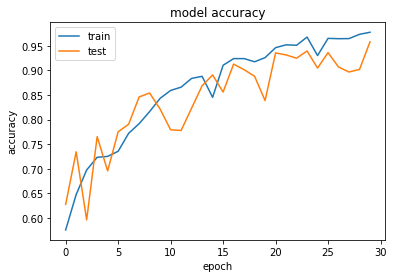

In [12]:
#plot train vs test accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = "train")
plt.plot(history.history['val_accuracy'], label = "test")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

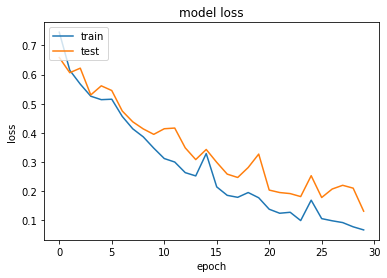

In [14]:
#plot train vs test loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = "test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

## Image Data Augmentation
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

In [15]:
# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare iterators
train_it = train_datagen.flow_from_directory('dataset_m_n/train/',
    class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = test_datagen.flow_from_directory('dataset_m_n/test/',
    class_mode='binary', batch_size=64, target_size=(200, 200))

Found 4501 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.


In [16]:
run_test_harness()

Found 4501 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Epoch 1/30
71/71 [==============================] - 10s 131ms/step - loss: 0.7735 - accuracy: 0.5361 - val_loss: 0.6870 - val_accuracy: 0.5150
Epoch 2/30
71/71 [==============================] - 9s 125ms/step - loss: 0.6654 - accuracy: 0.6181 - val_loss: 0.6629 - val_accuracy: 0.6144
Epoch 3/30
71/71 [==============================] - 9s 127ms/step - loss: 0.6136 - accuracy: 0.6554 - val_loss: 0.6530 - val_accuracy: 0.5664
Epoch 4/30
71/71 [==============================] - 9s 123ms/step - loss: 0.5988 - accuracy: 0.6679 - val_loss: 0.5769 - val_accuracy: 0.7285
Epoch 5/30
71/71 [==============================] - 9s 124ms/step - loss: 0.6139 - accuracy: 0.6636 - val_loss: 0.6295 - val_accuracy: 0.7058
Epoch 6/30
71/71 [==============================] - 9s 125ms/step - loss: 0.5386 - accuracy: 0.7190 - val_loss: 0.5572 - val_accuracy: 0.7398
Epoch 7/30
71/71 [==============================] - 9s 127ms/st

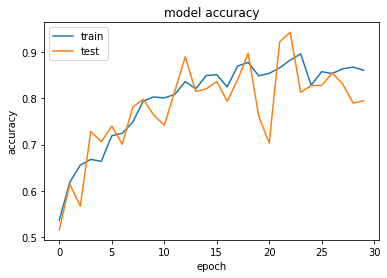

In [17]:
#plot train vs test accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label = "train")
plt.plot(history.history['val_accuracy'], label = "test")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

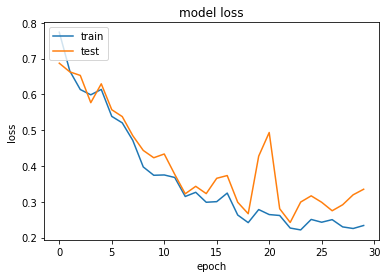

In [18]:
#plot train vs test loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = "test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()